In [14]:
# import packages & variables
import argparse
import torch
import torch.nn as nn
import numpy as np
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
from tqdm import tqdm
from transformers import AutoTokenizer, AutoModelForCausalLM, AutoModel, AutoModelForSequenceClassification
import json

# Parameters
model_name = 'meta-llama/Meta-Llama-3.1-8B'
non_infringement_file = '/home/guangwei/LLM-COPYRIGHT/copyright_newVersion/test_division/extra.non_infringement.json'
infringement_file = '/home/guangwei/LLM-COPYRIGHT/copyright_newVersion/test_division/extra.infringement.json'
checkpoint_file = '/home/guangwei/LLM-COPYRIGHT/copyright_newVersion/models/train_input_reference_last_layer_PCA.pth'


In [15]:
# Define CustumMLP for internal states train
class CustomMLP(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(CustomMLP, self).__init__()
        self.down = nn.Linear(input_dim, hidden_dim)
        self.gate = nn.Linear(input_dim, hidden_dim)
        self.up = nn.Linear(hidden_dim, 1)
        self.activation = nn.SiLU()

    def forward(self, x):
        down_output = self.down(x)
        gate_output = self.gate(x)
        gated_output = down_output * self.activation(gate_output)
        return self.up(gated_output)

In [16]:
# Extract hidden states/reference embeddings
from sklearn.decomposition import PCA

def extract_hidden_states(texts, model, tokenizer, apply_pca=True, n_components=3, batch_size=128):
    hidden_states = []
    for i in tqdm(range(0, len(texts), batch_size), desc="Processing data batches"):
        batch_texts = texts[i:i + batch_size]
        inputs = tokenizer(batch_texts, return_tensors="pt", padding=True, truncation=True)
        with torch.no_grad():
            outputs = model(**inputs)
        hidden_state = outputs.hidden_states[-1].mean(dim=1).cpu().numpy()
        hidden_states.append(hidden_state)

    hidden_states = np.vstack(hidden_states)
    
    # 应用 PCA 降维
    if apply_pca:
        pca = PCA(n_components=n_components)
        hidden_states = pca.fit_transform(hidden_states)
        print(f"Hidden states reduced to {n_components} dimensions using PCA.")
        
    return hidden_states

def extract_reference_embeddings(references, model, tokenizer, batch_size=128):
    embeddings = []
    for i in tqdm(range(0, len(references), batch_size), desc="Processing references"):
        batch_references = references[i:i + batch_size]
        inputs = tokenizer(batch_references, return_tensors="pt", padding=True, truncation=True)
        with torch.no_grad():
            outputs = model(**inputs)
        embeddings.append(outputs.pooler_output.cpu().numpy())
    return np.vstack(embeddings)

In [17]:
# load data for infringement & non infringement
def load_data(non_infringement_file, infringement_file):
    with open(non_infringement_file, 'r', encoding='utf-8') as file:
        non_infringement_json_data = json.load(file)

    non_infringement_outputs = [entry['input'] for entry in non_infringement_json_data]
    non_infringement_references = [entry['reference'] for entry in non_infringement_json_data]
    y_non_infringement = [1] * len(non_infringement_outputs)

    with open(infringement_file, 'r', encoding='utf-8') as file:
        infringement_json_data = json.load(file)

    infringement_outputs = [entry['input'] for entry in infringement_json_data]
    infringement_references = [entry['reference'] for entry in infringement_json_data]
    y_infringement = [0] * len(infringement_outputs)

    return non_infringement_outputs, non_infringement_references, y_non_infringement, infringement_outputs, infringement_references, y_infringement

In [18]:
# Train for best model
def train_model(X_train, y_train, X_test, y_test, input_dim, hidden_dim, epochs=500, lr=0.001, checkpoint_path=checkpoint_file):
    custom_mlp = CustomMLP(input_dim, hidden_dim)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(custom_mlp.parameters(), lr=lr)

    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)

    best_accuracy = -float('inf')
    best_model_state = None
    best_epoch = 0
    losses = []

    for epoch in tqdm(range(epochs), desc="Training Epochs"):
        custom_mlp.train()
        optimizer.zero_grad()
        outputs = custom_mlp(X_train_tensor)
        loss = criterion(outputs, y_train_tensor)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss.item():.4f}")
            
            custom_mlp.eval()
            X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
            with torch.no_grad():
                y_pred_logits = custom_mlp(X_test_tensor)
                y_pred = (torch.sigmoid(y_pred_logits) > 0.5).float().numpy()
            
            accuracy = accuracy_score(y_test, y_pred)
            print(f"Test Accuracy at Epoch {epoch + 1}: {accuracy * 100:.2f}%")
            
            report = classification_report(y_test, y_pred, target_names=["infringement", "non_infringement"])
            print(f"Classification Report at Epoch {epoch + 1}:\n{report}")

            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_model_state = custom_mlp.state_dict()
                best_epoch = epoch + 1
                torch.save(best_model_state, checkpoint_path)
                print(f"New best model saved with accuracy {best_accuracy * 100:.2f}% at epoch {best_epoch}")
                print(f"Best Classification Report at Epoch {best_epoch}:\n{report}")

    custom_mlp.load_state_dict(torch.load(checkpoint_path))

    plt.figure(figsize=(10, 5))
    plt.plot(losses, label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss Curve')
    plt.legend()
    plt.show()

    print(f"Final Model Accuracy: {best_accuracy * 100:.2f}%")
    
    return custom_mlp, losses, best_accuracy

In [19]:
tokenizer = AutoTokenizer.from_pretrained(model_name, model_max_length=512)
model = AutoModelForCausalLM.from_pretrained(model_name, output_hidden_states=True)
tokenizer.pad_token = tokenizer.eos_token
bert_tokenizer = AutoTokenizer.from_pretrained('google-bert/bert-base-uncased')
bert_model = AutoModel.from_pretrained('google-bert/bert-base-uncased')
bert_tokenizer.pad_token = tokenizer.eos_token

non_infringement_outputs, non_infringement_references, y_non_infringement, infringement_outputs, infringement_references, y_infringement = load_data(
    non_infringement_file, infringement_file
)

y_non_infringement = np.array(y_non_infringement)
y_infringement = np.array(y_infringement)


/home/guangwei/anaconda3/envs/sit/lib/python3.8/site-packages/transformers/generation/configuration_utils.py:777: UserWarning: `return_dict_in_generate` is NOT set to `True`, but `output_hidden_states` is. When `return_dict_in_generate` is not `True`, `output_hidden_states` is ignored.
  warnings.warn(
Loading checkpoint shards: 100%|██████████| 4/4 [00:02<00:00,  1.43it/s]
/home/guangwei/anaconda3/envs/sit/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [20]:
print("Extracting hidden states for non_infringement texts...")
X_non_infringement = extract_hidden_states(non_infringement_outputs, model, tokenizer)
print("Extracting reference embeddings for non_infringement texts...")
reference_embeddings_non_infringement = extract_reference_embeddings(non_infringement_references, bert_model, bert_tokenizer)
X_non_infringement_combined = np.hstack([X_non_infringement, reference_embeddings_non_infringement])

print("Extracting hidden states for infringement texts...")
X_infringement = extract_hidden_states(infringement_outputs, model, tokenizer)
print("Extracting reference embeddings for infringement texts...")
reference_embeddings_infringement = extract_reference_embeddings(infringement_references, bert_model, bert_tokenizer)
X_infringement_combined = np.hstack([X_infringement, reference_embeddings_infringement])

Extracting hidden states for non_infringement texts...


Processing data batches: 100%|██████████| 12/12 [18:19<00:00, 91.60s/it]


Hidden states reduced to 3 dimensions using PCA.
Extracting reference embeddings for non_infringement texts...


Processing references: 100%|██████████| 12/12 [00:44<00:00,  3.70s/it]


Extracting hidden states for infringement texts...


Processing data batches: 100%|██████████| 12/12 [19:39<00:00, 98.30s/it]


Hidden states reduced to 3 dimensions using PCA.
Extracting reference embeddings for infringement texts...


Processing references: 100%|██████████| 12/12 [01:19<00:00,  6.61s/it]


In [21]:
split_index_non_infringement = int(0.8 * len(X_non_infringement_combined))
X_non_infringement_train = X_non_infringement_combined[:split_index_non_infringement]
X_non_infringement_test = X_non_infringement_combined[split_index_non_infringement:]
y_non_infringement_train = y_non_infringement[:split_index_non_infringement]
y_non_infringement_test = y_non_infringement[split_index_non_infringement:]

split_index_infringement = int(0.8 * len(X_infringement_combined))
X_infringement_train = X_infringement_combined[:split_index_infringement]
X_infringement_test = X_infringement_combined[split_index_infringement:]
y_infringement_train = y_infringement[:split_index_infringement]
y_infringement_test = y_infringement[split_index_infringement:]

X_train = np.vstack((X_non_infringement_train, X_infringement_train))
X_test = np.vstack((X_non_infringement_test, X_infringement_test))
y_train = np.concatenate((y_non_infringement_train, y_infringement_train))
y_test = np.concatenate((y_non_infringement_test, y_infringement_test))

print("Data successfully split into training and test sets.")

Data successfully split into training and test sets.


Training MLP model with input_dim=771 and hidden_dim=256


Training Epochs:   0%|          | 0/500 [00:00<?, ?it/s]/home/guangwei/anaconda3/envs/sit/lib/python3.8/site-packages/torch/autograd/graph.py:768: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11040). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
Training Epochs:   3%|▎         | 15/500 [00:02<00:34, 13.93it/s]

Epoch 10/500, Loss: 0.5889
Test Accuracy at Epoch 10: 46.82%
Classification Report at Epoch 10:
                  precision    recall  f1-score   support

    infringement       0.46      0.52      0.49       283
non_infringement       0.48      0.42      0.45       298

        accuracy                           0.47       581
       macro avg       0.47      0.47      0.47       581
    weighted avg       0.47      0.47      0.47       581

New best model saved with accuracy 46.82% at epoch 10
Best Classification Report at Epoch 10:
                  precision    recall  f1-score   support

    infringement       0.46      0.52      0.49       283
non_infringement       0.48      0.42      0.45       298

        accuracy                           0.47       581
       macro avg       0.47      0.47      0.47       581
    weighted avg       0.47      0.47      0.47       581

Epoch 20/500, Loss: 0.5196
Test Accuracy at Epoch 20: 52.15%
Classification Report at Epoch 20:
            

Training Epochs:   6%|▌         | 30/500 [00:06<02:19,  3.37it/s]

Epoch 30/500, Loss: 0.4596
Test Accuracy at Epoch 30: 55.77%
Classification Report at Epoch 30:
                  precision    recall  f1-score   support

    infringement       0.55      0.47      0.51       283
non_infringement       0.56      0.64      0.60       298

        accuracy                           0.56       581
       macro avg       0.56      0.56      0.55       581
    weighted avg       0.56      0.56      0.55       581

New best model saved with accuracy 55.77% at epoch 30
Best Classification Report at Epoch 30:
                  precision    recall  f1-score   support

    infringement       0.55      0.47      0.51       283
non_infringement       0.56      0.64      0.60       298

        accuracy                           0.56       581
       macro avg       0.56      0.56      0.55       581
    weighted avg       0.56      0.56      0.55       581



Training Epochs:   8%|▊         | 40/500 [00:11<03:43,  2.06it/s]

Epoch 40/500, Loss: 0.4132
Test Accuracy at Epoch 40: 57.31%
Classification Report at Epoch 40:
                  precision    recall  f1-score   support

    infringement       0.62      0.33      0.43       283
non_infringement       0.56      0.81      0.66       298

        accuracy                           0.57       581
       macro avg       0.59      0.57      0.54       581
    weighted avg       0.59      0.57      0.55       581

New best model saved with accuracy 57.31% at epoch 40
Best Classification Report at Epoch 40:
                  precision    recall  f1-score   support

    infringement       0.62      0.33      0.43       283
non_infringement       0.56      0.81      0.66       298

        accuracy                           0.57       581
       macro avg       0.59      0.57      0.54       581
    weighted avg       0.59      0.57      0.55       581



Training Epochs:  10%|█         | 50/500 [00:16<03:51,  1.94it/s]

Epoch 50/500, Loss: 0.3762
Test Accuracy at Epoch 50: 58.00%
Classification Report at Epoch 50:
                  precision    recall  f1-score   support

    infringement       0.62      0.35      0.45       283
non_infringement       0.56      0.80      0.66       298

        accuracy                           0.58       581
       macro avg       0.59      0.57      0.56       581
    weighted avg       0.59      0.58      0.56       581

New best model saved with accuracy 58.00% at epoch 50
Best Classification Report at Epoch 50:
                  precision    recall  f1-score   support

    infringement       0.62      0.35      0.45       283
non_infringement       0.56      0.80      0.66       298

        accuracy                           0.58       581
       macro avg       0.59      0.57      0.56       581
    weighted avg       0.59      0.58      0.56       581



Training Epochs:  12%|█▏        | 60/500 [00:21<03:50,  1.91it/s]

Epoch 60/500, Loss: 0.3359
Test Accuracy at Epoch 60: 62.48%
Classification Report at Epoch 60:
                  precision    recall  f1-score   support

    infringement       0.67      0.46      0.54       283
non_infringement       0.60      0.79      0.68       298

        accuracy                           0.62       581
       macro avg       0.64      0.62      0.61       581
    weighted avg       0.63      0.62      0.61       581

New best model saved with accuracy 62.48% at epoch 60
Best Classification Report at Epoch 60:
                  precision    recall  f1-score   support

    infringement       0.67      0.46      0.54       283
non_infringement       0.60      0.79      0.68       298

        accuracy                           0.62       581
       macro avg       0.64      0.62      0.61       581
    weighted avg       0.63      0.62      0.61       581



Training Epochs:  14%|█▍        | 70/500 [00:26<03:34,  2.00it/s]

Epoch 70/500, Loss: 0.3006
Test Accuracy at Epoch 70: 62.99%
Classification Report at Epoch 70:
                  precision    recall  f1-score   support

    infringement       0.65      0.52      0.58       283
non_infringement       0.62      0.74      0.67       298

        accuracy                           0.63       581
       macro avg       0.63      0.63      0.62       581
    weighted avg       0.63      0.63      0.63       581

New best model saved with accuracy 62.99% at epoch 70
Best Classification Report at Epoch 70:
                  precision    recall  f1-score   support

    infringement       0.65      0.52      0.58       283
non_infringement       0.62      0.74      0.67       298

        accuracy                           0.63       581
       macro avg       0.63      0.63      0.62       581
    weighted avg       0.63      0.63      0.63       581



Training Epochs:  16%|█▌        | 79/500 [00:29<02:39,  2.63it/s]

Epoch 80/500, Loss: 0.2827
Test Accuracy at Epoch 80: 66.95%
Classification Report at Epoch 80:
                  precision    recall  f1-score   support

    infringement       0.65      0.70      0.67       283
non_infringement       0.69      0.64      0.67       298

        accuracy                           0.67       581
       macro avg       0.67      0.67      0.67       581
    weighted avg       0.67      0.67      0.67       581



Training Epochs:  16%|█▌        | 81/500 [00:30<02:40,  2.61it/s]

New best model saved with accuracy 66.95% at epoch 80
Best Classification Report at Epoch 80:
                  precision    recall  f1-score   support

    infringement       0.65      0.70      0.67       283
non_infringement       0.69      0.64      0.67       298

        accuracy                           0.67       581
       macro avg       0.67      0.67      0.67       581
    weighted avg       0.67      0.67      0.67       581



Training Epochs:  18%|█▊        | 89/500 [00:30<00:40, 10.03it/s]

Epoch 90/500, Loss: 0.2364
Test Accuracy at Epoch 90: 66.61%
Classification Report at Epoch 90:
                  precision    recall  f1-score   support

    infringement       0.68      0.60      0.64       283
non_infringement       0.66      0.72      0.69       298

        accuracy                           0.67       581
       macro avg       0.67      0.66      0.66       581
    weighted avg       0.67      0.67      0.66       581



Training Epochs:  20%|██        | 100/500 [00:31<01:06,  6.01it/s]

Epoch 100/500, Loss: 0.2229
Test Accuracy at Epoch 100: 69.54%
Classification Report at Epoch 100:
                  precision    recall  f1-score   support

    infringement       0.77      0.54      0.63       283
non_infringement       0.66      0.85      0.74       298

        accuracy                           0.70       581
       macro avg       0.71      0.69      0.69       581
    weighted avg       0.71      0.70      0.69       581

New best model saved with accuracy 69.54% at epoch 100
Best Classification Report at Epoch 100:
                  precision    recall  f1-score   support

    infringement       0.77      0.54      0.63       283
non_infringement       0.66      0.85      0.74       298

        accuracy                           0.70       581
       macro avg       0.71      0.69      0.69       581
    weighted avg       0.71      0.70      0.69       581



Training Epochs:  22%|██▏       | 110/500 [00:33<01:12,  5.37it/s]

Epoch 110/500, Loss: 0.2111
Test Accuracy at Epoch 110: 69.71%
Classification Report at Epoch 110:
                  precision    recall  f1-score   support

    infringement       0.71      0.64      0.67       283
non_infringement       0.69      0.75      0.72       298

        accuracy                           0.70       581
       macro avg       0.70      0.70      0.70       581
    weighted avg       0.70      0.70      0.70       581

New best model saved with accuracy 69.71% at epoch 110
Best Classification Report at Epoch 110:
                  precision    recall  f1-score   support

    infringement       0.71      0.64      0.67       283
non_infringement       0.69      0.75      0.72       298

        accuracy                           0.70       581
       macro avg       0.70      0.70      0.70       581
    weighted avg       0.70      0.70      0.70       581



Training Epochs:  25%|██▍       | 123/500 [00:34<00:27, 13.55it/s]

Epoch 120/500, Loss: 0.1674
Test Accuracy at Epoch 120: 69.02%
Classification Report at Epoch 120:
                  precision    recall  f1-score   support

    infringement       0.74      0.57      0.64       283
non_infringement       0.66      0.81      0.73       298

        accuracy                           0.69       581
       macro avg       0.70      0.69      0.68       581
    weighted avg       0.70      0.69      0.69       581



Training Epochs:  26%|██▌       | 130/500 [00:35<00:56,  6.58it/s]

Epoch 130/500, Loss: 0.1518
Test Accuracy at Epoch 130: 71.26%
Classification Report at Epoch 130:
                  precision    recall  f1-score   support

    infringement       0.80      0.54      0.65       283
non_infringement       0.67      0.87      0.76       298

        accuracy                           0.71       581
       macro avg       0.74      0.71      0.70       581
    weighted avg       0.73      0.71      0.70       581

New best model saved with accuracy 71.26% at epoch 130
Best Classification Report at Epoch 130:
                  precision    recall  f1-score   support

    infringement       0.80      0.54      0.65       283
non_infringement       0.67      0.87      0.76       298

        accuracy                           0.71       581
       macro avg       0.74      0.71      0.70       581
    weighted avg       0.73      0.71      0.70       581



Training Epochs:  28%|██▊       | 140/500 [00:36<00:48,  7.49it/s]

Epoch 140/500, Loss: 0.1395
Test Accuracy at Epoch 140: 71.26%
Classification Report at Epoch 140:
                  precision    recall  f1-score   support

    infringement       0.75      0.61      0.68       283
non_infringement       0.69      0.81      0.74       298

        accuracy                           0.71       581
       macro avg       0.72      0.71      0.71       581
    weighted avg       0.72      0.71      0.71       581



Training Epochs:  30%|██▉       | 149/500 [00:38<00:44,  7.84it/s]

Epoch 150/500, Loss: 0.1270
Test Accuracy at Epoch 150: 72.98%
Classification Report at Epoch 150:
                  precision    recall  f1-score   support

    infringement       0.81      0.58      0.67       283
non_infringement       0.69      0.88      0.77       298

        accuracy                           0.73       581
       macro avg       0.75      0.73      0.72       581
    weighted avg       0.75      0.73      0.72       581

New best model saved with accuracy 72.98% at epoch 150
Best Classification Report at Epoch 150:
                  precision    recall  f1-score   support

    infringement       0.81      0.58      0.67       283
non_infringement       0.69      0.88      0.77       298

        accuracy                           0.73       581
       macro avg       0.75      0.73      0.72       581
    weighted avg       0.75      0.73      0.72       581



Training Epochs:  33%|███▎      | 165/500 [00:39<00:22, 14.65it/s]

Epoch 160/500, Loss: 0.1175
Test Accuracy at Epoch 160: 73.32%
Classification Report at Epoch 160:
                  precision    recall  f1-score   support

    infringement       0.77      0.65      0.70       283
non_infringement       0.71      0.81      0.76       298

        accuracy                           0.73       581
       macro avg       0.74      0.73      0.73       581
    weighted avg       0.74      0.73      0.73       581

New best model saved with accuracy 73.32% at epoch 160
Best Classification Report at Epoch 160:
                  precision    recall  f1-score   support

    infringement       0.77      0.65      0.70       283
non_infringement       0.71      0.81      0.76       298

        accuracy                           0.73       581
       macro avg       0.74      0.73      0.73       581
    weighted avg       0.74      0.73      0.73       581



Training Epochs:  36%|███▌      | 179/500 [00:40<00:11, 27.34it/s]

Epoch 170/500, Loss: 0.1029
Test Accuracy at Epoch 170: 72.12%
Classification Report at Epoch 170:
                  precision    recall  f1-score   support

    infringement       0.79      0.58      0.67       283
non_infringement       0.68      0.85      0.76       298

        accuracy                           0.72       581
       macro avg       0.74      0.72      0.71       581
    weighted avg       0.73      0.72      0.72       581

Epoch 180/500, Loss: 0.0935
Test Accuracy at Epoch 180: 71.08%
Classification Report at Epoch 180:
                  precision    recall  f1-score   support

    infringement       0.76      0.59      0.67       283
non_infringement       0.68      0.83      0.75       298

        accuracy                           0.71       581
       macro avg       0.72      0.71      0.71       581
    weighted avg       0.72      0.71      0.71       581



Training Epochs:  38%|███▊      | 191/500 [00:42<00:25, 12.05it/s]

Epoch 190/500, Loss: 0.0820
Test Accuracy at Epoch 190: 71.26%
Classification Report at Epoch 190:
                  precision    recall  f1-score   support

    infringement       0.77      0.59      0.67       283
non_infringement       0.68      0.83      0.75       298

        accuracy                           0.71       581
       macro avg       0.72      0.71      0.71       581
    weighted avg       0.72      0.71      0.71       581



Training Epochs:  40%|████      | 200/500 [00:43<00:35,  8.46it/s]

Epoch 200/500, Loss: 0.0804
Test Accuracy at Epoch 200: 69.19%
Classification Report at Epoch 200:
                  precision    recall  f1-score   support

    infringement       0.78      0.51      0.62       283
non_infringement       0.65      0.86      0.74       298

        accuracy                           0.69       581
       macro avg       0.72      0.69      0.68       581
    weighted avg       0.71      0.69      0.68       581



Training Epochs:  42%|████▏     | 210/500 [00:45<01:03,  4.54it/s]

Epoch 210/500, Loss: 0.0769
Test Accuracy at Epoch 210: 71.43%
Classification Report at Epoch 210:
                  precision    recall  f1-score   support

    infringement       0.77      0.59      0.67       283
non_infringement       0.68      0.83      0.75       298

        accuracy                           0.71       581
       macro avg       0.73      0.71      0.71       581
    weighted avg       0.72      0.71      0.71       581



Training Epochs:  44%|████▍     | 220/500 [00:51<02:25,  1.92it/s]

Epoch 220/500, Loss: 0.0619
Test Accuracy at Epoch 220: 68.16%
Classification Report at Epoch 220:
                  precision    recall  f1-score   support

    infringement       0.75      0.52      0.61       283
non_infringement       0.65      0.84      0.73       298

        accuracy                           0.68       581
       macro avg       0.70      0.68      0.67       581
    weighted avg       0.70      0.68      0.67       581



Training Epochs:  46%|████▌     | 230/500 [00:56<02:31,  1.78it/s]

Epoch 230/500, Loss: 0.0535
Test Accuracy at Epoch 230: 71.60%
Classification Report at Epoch 230:
                  precision    recall  f1-score   support

    infringement       0.77      0.59      0.67       283
non_infringement       0.68      0.84      0.75       298

        accuracy                           0.72       581
       macro avg       0.73      0.71      0.71       581
    weighted avg       0.73      0.72      0.71       581



Training Epochs:  48%|████▊     | 240/500 [01:00<02:06,  2.06it/s]

Epoch 240/500, Loss: 0.0482
Test Accuracy at Epoch 240: 71.94%
Classification Report at Epoch 240:
                  precision    recall  f1-score   support

    infringement       0.78      0.60      0.67       283
non_infringement       0.69      0.84      0.75       298

        accuracy                           0.72       581
       macro avg       0.73      0.72      0.71       581
    weighted avg       0.73      0.72      0.72       581



Training Epochs:  50%|█████     | 250/500 [01:06<02:18,  1.81it/s]

Epoch 250/500, Loss: 0.0436
Test Accuracy at Epoch 250: 72.29%
Classification Report at Epoch 250:
                  precision    recall  f1-score   support

    infringement       0.78      0.60      0.68       283
non_infringement       0.69      0.84      0.76       298

        accuracy                           0.72       581
       macro avg       0.73      0.72      0.72       581
    weighted avg       0.73      0.72      0.72       581



Training Epochs:  52%|█████▏    | 260/500 [01:11<02:06,  1.90it/s]

Epoch 260/500, Loss: 0.4870
Test Accuracy at Epoch 260: 53.70%
Classification Report at Epoch 260:
                  precision    recall  f1-score   support

    infringement       0.73      0.08      0.14       283
non_infringement       0.53      0.97      0.68       298

        accuracy                           0.54       581
       macro avg       0.63      0.53      0.41       581
    weighted avg       0.63      0.54      0.42       581



Training Epochs:  54%|█████▍    | 269/500 [01:15<01:58,  1.95it/s]

Epoch 270/500, Loss: 0.3139
Test Accuracy at Epoch 270: 72.63%


Training Epochs:  54%|█████▍    | 270/500 [01:16<02:08,  1.79it/s]

Classification Report at Epoch 270:
                  precision    recall  f1-score   support

    infringement       0.83      0.55      0.66       283
non_infringement       0.68      0.89      0.77       298

        accuracy                           0.73       581
       macro avg       0.75      0.72      0.72       581
    weighted avg       0.75      0.73      0.72       581



Training Epochs:  56%|█████▌    | 280/500 [01:21<01:52,  1.96it/s]

Epoch 280/500, Loss: 0.1734
Test Accuracy at Epoch 280: 73.32%
Classification Report at Epoch 280:
                  precision    recall  f1-score   support

    infringement       0.83      0.57      0.67       283
non_infringement       0.68      0.89      0.77       298

        accuracy                           0.73       581
       macro avg       0.76      0.73      0.72       581
    weighted avg       0.76      0.73      0.73       581



Training Epochs:  57%|█████▋    | 283/500 [01:22<01:34,  2.30it/s]

Epoch 290/500, Loss: 0.1258
Test Accuracy at Epoch 290: 72.63%
Classification Report at Epoch 290:
                  precision    recall  f1-score   support

    infringement       0.80      0.58      0.67       283
non_infringement       0.69      0.86      0.76       298

        accuracy                           0.73       581
       macro avg       0.74      0.72      0.72       581
    weighted avg       0.74      0.73      0.72       581



Training Epochs:  60%|██████    | 300/500 [01:27<01:35,  2.10it/s]

Epoch 300/500, Loss: 0.0924
Test Accuracy at Epoch 300: 68.33%
Classification Report at Epoch 300:
                  precision    recall  f1-score   support

    infringement       0.76      0.52      0.61       283
non_infringement       0.65      0.84      0.73       298

        accuracy                           0.68       581
       macro avg       0.70      0.68      0.67       581
    weighted avg       0.70      0.68      0.67       581



Training Epochs:  62%|██████▏   | 310/500 [01:33<01:43,  1.83it/s]

Epoch 310/500, Loss: 0.0759
Test Accuracy at Epoch 310: 67.99%
Classification Report at Epoch 310:
                  precision    recall  f1-score   support

    infringement       0.76      0.51      0.61       283
non_infringement       0.64      0.85      0.73       298

        accuracy                           0.68       581
       macro avg       0.70      0.68      0.67       581
    weighted avg       0.70      0.68      0.67       581



Training Epochs:  64%|██████▍   | 322/500 [01:33<00:15, 11.75it/s]

Epoch 320/500, Loss: 0.0648
Test Accuracy at Epoch 320: 68.67%
Classification Report at Epoch 320:
                  precision    recall  f1-score   support

    infringement       0.76      0.52      0.62       283
non_infringement       0.65      0.85      0.73       298

        accuracy                           0.69       581
       macro avg       0.71      0.68      0.68       581
    weighted avg       0.70      0.69      0.68       581



Training Epochs:  66%|██████▌   | 329/500 [01:36<00:39,  4.38it/s]

Epoch 330/500, Loss: 0.0582
Test Accuracy at Epoch 330: 69.36%
Classification Report at Epoch 330:
                  precision    recall  f1-score   support

    infringement       0.78      0.52      0.62       283
non_infringement       0.65      0.86      0.74       298

        accuracy                           0.69       581
       macro avg       0.72      0.69      0.68       581
    weighted avg       0.71      0.69      0.68       581



Training Epochs:  68%|██████▊   | 340/500 [01:41<01:27,  1.83it/s]

Epoch 340/500, Loss: 0.0534
Test Accuracy at Epoch 340: 69.36%
Classification Report at Epoch 340:
                  precision    recall  f1-score   support

    infringement       0.78      0.52      0.62       283
non_infringement       0.65      0.86      0.74       298

        accuracy                           0.69       581
       macro avg       0.72      0.69      0.68       581
    weighted avg       0.71      0.69      0.68       581



Training Epochs:  70%|███████   | 350/500 [01:46<01:19,  1.89it/s]

Epoch 350/500, Loss: 0.0497
Test Accuracy at Epoch 350: 68.85%
Classification Report at Epoch 350:
                  precision    recall  f1-score   support

    infringement       0.77      0.52      0.62       283
non_infringement       0.65      0.85      0.74       298

        accuracy                           0.69       581
       macro avg       0.71      0.68      0.68       581
    weighted avg       0.71      0.69      0.68       581



Training Epochs:  76%|███████▌  | 378/500 [01:51<00:06, 18.24it/s]

Epoch 360/500, Loss: 0.0467
Test Accuracy at Epoch 360: 68.85%
Classification Report at Epoch 360:
                  precision    recall  f1-score   support

    infringement       0.77      0.52      0.62       283
non_infringement       0.65      0.85      0.74       298

        accuracy                           0.69       581
       macro avg       0.71      0.68      0.68       581
    weighted avg       0.71      0.69      0.68       581

Epoch 370/500, Loss: 0.0441
Test Accuracy at Epoch 370: 68.85%
Classification Report at Epoch 370:
                  precision    recall  f1-score   support

    infringement       0.77      0.52      0.62       283
non_infringement       0.65      0.85      0.74       298

        accuracy                           0.69       581
       macro avg       0.71      0.68      0.68       581
    weighted avg       0.71      0.69      0.68       581



Training Epochs:  77%|███████▋  | 383/500 [01:51<00:05, 20.13it/s]

Epoch 380/500, Loss: 0.0418
Test Accuracy at Epoch 380: 71.26%
Classification Report at Epoch 380:
                  precision    recall  f1-score   support

    infringement       0.77      0.59      0.67       283
non_infringement       0.68      0.83      0.75       298

        accuracy                           0.71       581
       macro avg       0.72      0.71      0.71       581
    weighted avg       0.72      0.71      0.71       581

Epoch 390/500, Loss: 0.0398
Test Accuracy at Epoch 390: 71.08%
Classification Report at Epoch 390:
                  precision    recall  f1-score   support

    infringement       0.76      0.59      0.67       283
non_infringement       0.68      0.83      0.75       298

        accuracy                           0.71       581
       macro avg       0.72      0.71      0.71       581
    weighted avg       0.72      0.71      0.71       581



Training Epochs:  80%|████████  | 402/500 [01:53<00:09, 10.73it/s]

Epoch 400/500, Loss: 0.0379
Test Accuracy at Epoch 400: 70.74%
Classification Report at Epoch 400:
                  precision    recall  f1-score   support

    infringement       0.76      0.58      0.66       283
non_infringement       0.68      0.83      0.74       298

        accuracy                           0.71       581
       macro avg       0.72      0.70      0.70       581
    weighted avg       0.72      0.71      0.70       581



Training Epochs:  82%|████████▏ | 409/500 [01:54<00:08, 11.22it/s]

Epoch 410/500, Loss: 0.0362
Test Accuracy at Epoch 410: 70.74%
Classification Report at Epoch 410:
                  precision    recall  f1-score   support

    infringement       0.76      0.58      0.66       283
non_infringement       0.68      0.83      0.74       298

        accuracy                           0.71       581
       macro avg       0.72      0.70      0.70       581
    weighted avg       0.72      0.71      0.70       581



Training Epochs:  84%|████████▍ | 420/500 [01:59<00:33,  2.38it/s]

Epoch 420/500, Loss: 0.0346
Test Accuracy at Epoch 420: 70.74%
Classification Report at Epoch 420:
                  precision    recall  f1-score   support

    infringement       0.76      0.58      0.66       283
non_infringement       0.68      0.83      0.74       298

        accuracy                           0.71       581
       macro avg       0.72      0.70      0.70       581
    weighted avg       0.72      0.71      0.70       581



Training Epochs:  86%|████████▌ | 430/500 [02:04<00:37,  1.85it/s]

Epoch 430/500, Loss: 0.0331
Test Accuracy at Epoch 430: 70.74%
Classification Report at Epoch 430:
                  precision    recall  f1-score   support

    infringement       0.76      0.58      0.66       283
non_infringement       0.68      0.83      0.74       298

        accuracy                           0.71       581
       macro avg       0.72      0.70      0.70       581
    weighted avg       0.72      0.71      0.70       581



Training Epochs:  88%|████████▊ | 440/500 [02:09<00:31,  1.88it/s]

Epoch 440/500, Loss: 0.0316
Test Accuracy at Epoch 440: 70.74%
Classification Report at Epoch 440:
                  precision    recall  f1-score   support

    infringement       0.76      0.58      0.66       283
non_infringement       0.68      0.83      0.74       298

        accuracy                           0.71       581
       macro avg       0.72      0.70      0.70       581
    weighted avg       0.72      0.71      0.70       581



Training Epochs:  90%|█████████ | 450/500 [02:15<00:29,  1.67it/s]

Epoch 450/500, Loss: 0.0303
Test Accuracy at Epoch 450: 70.74%
Classification Report at Epoch 450:
                  precision    recall  f1-score   support

    infringement       0.76      0.58      0.66       283
non_infringement       0.68      0.83      0.74       298

        accuracy                           0.71       581
       macro avg       0.72      0.70      0.70       581
    weighted avg       0.72      0.71      0.70       581



Training Epochs:  92%|█████████▏| 460/500 [02:20<00:21,  1.88it/s]

Epoch 460/500, Loss: 0.0290
Test Accuracy at Epoch 460: 70.74%
Classification Report at Epoch 460:
                  precision    recall  f1-score   support

    infringement       0.76      0.58      0.66       283
non_infringement       0.68      0.83      0.74       298

        accuracy                           0.71       581
       macro avg       0.72      0.70      0.70       581
    weighted avg       0.72      0.71      0.70       581



Training Epochs:  94%|█████████▍| 470/500 [02:25<00:16,  1.84it/s]

Epoch 470/500, Loss: 0.0277
Test Accuracy at Epoch 470: 71.08%
Classification Report at Epoch 470:
                  precision    recall  f1-score   support

    infringement       0.76      0.59      0.67       283
non_infringement       0.68      0.83      0.75       298

        accuracy                           0.71       581
       macro avg       0.72      0.71      0.71       581
    weighted avg       0.72      0.71      0.71       581



Training Epochs:  96%|█████████▌| 478/500 [02:29<00:08,  2.61it/s]

Epoch 480/500, Loss: 0.0264
Test Accuracy at Epoch 480: 71.08%
Classification Report at Epoch 480:
                  precision    recall  f1-score   support

    infringement       0.76      0.59      0.67       283
non_infringement       0.68      0.83      0.75       298

        accuracy                           0.71       581
       macro avg       0.72      0.71      0.71       581
    weighted avg       0.72      0.71      0.71       581



Training Epochs:  98%|█████████▊| 490/500 [02:34<00:05,  1.95it/s]

Epoch 490/500, Loss: 0.0255
Test Accuracy at Epoch 490: 71.08%
Classification Report at Epoch 490:
                  precision    recall  f1-score   support

    infringement       0.76      0.59      0.67       283
non_infringement       0.68      0.83      0.75       298

        accuracy                           0.71       581
       macro avg       0.72      0.71      0.71       581
    weighted avg       0.72      0.71      0.71       581



Training Epochs: 100%|██████████| 500/500 [02:39<00:00,  3.14it/s]

Epoch 500/500, Loss: 0.0240
Test Accuracy at Epoch 500: 71.08%
Classification Report at Epoch 500:
                  precision    recall  f1-score   support

    infringement       0.76      0.59      0.67       283
non_infringement       0.68      0.83      0.75       298

        accuracy                           0.71       581
       macro avg       0.72      0.71      0.71       581
    weighted avg       0.72      0.71      0.71       581




/tmp/ipykernel_395335/1033092828.py:47: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  custom_mlp.load_state_dict(torch.load(checkpoint_path))


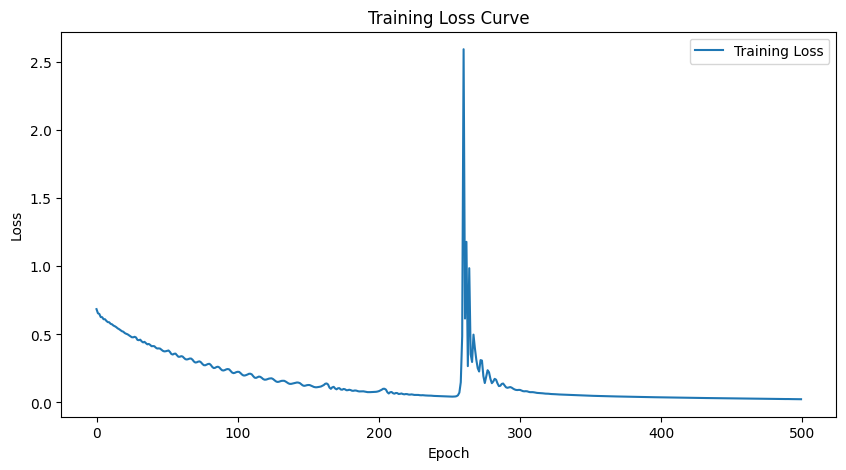

Final Model Accuracy: 73.32%


In [22]:
input_dim = X_train.shape[1]
hidden_dim = 256 
print(f"Training MLP model with input_dim={input_dim} and hidden_dim={hidden_dim}")

custom_mlp, losses, best_accuracy = train_model(X_train, y_train, X_test, y_test, input_dim, hidden_dim)

In [23]:
def save_checkpoint(model, optimizer, epoch, loss, filepath):
    checkpoint = {
        'epoch': epoch + 1,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss
    }
    torch.save(checkpoint, filepath)
    print(f"Checkpoint saved to '{filepath}'.")

save_checkpoint(custom_mlp, torch.optim.Adam(custom_mlp.parameters()), len(losses), losses[-1], checkpoint_file)

Checkpoint saved to '/home/guangwei/LLM-COPYRIGHT/copyright_newVersion/models/train_input_reference_last_layer_PCA.pth'.


In [24]:
y_pred_final = (torch.sigmoid(torch.tensor(custom_mlp(torch.tensor(X_test, dtype=torch.float32)))) > 0.5).float().numpy()
print(classification_report(y_test, y_pred_final, target_names=["infringement", "non_infringement"]))

                  precision    recall  f1-score   support

    infringement       0.77      0.65      0.70       283
non_infringement       0.71      0.81      0.76       298

        accuracy                           0.73       581
       macro avg       0.74      0.73      0.73       581
    weighted avg       0.74      0.73      0.73       581



/tmp/ipykernel_395335/2137335780.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_pred_final = (torch.sigmoid(torch.tensor(custom_mlp(torch.tensor(X_test, dtype=torch.float32)))) > 0.5).float().numpy()
